# PEEK Box Extraction

## Run Inference and Save Feature Maps

(Note: for large datasets, this will create tens of GB of data. Please ensure you have sufficient hard drive space.)

In [2]:
!python yolov5/detect.py --weights satellite_detection_weights.pt --source TestData --save-feature-maps feature_maps/GSFC --save-txt --save-conf --save-crop --name PEEK_boxes

detect: weights=['satellite_detection_weights.pt'], source=TestData, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=PEEK_boxes, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, save_feature_maps=feature_maps/GSFC
YOLOv5  2024-9-4 Python-3.9.16 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 C:\Users\Ryan\GitHub\Kenzie_PEEK_testing\TestData\frame00000.png: 384x640 2 antennas, 3 bodys, 2 solars, 95.7ms
image 2/8 C:\Users\Ryan\GitHub\Kenzie_PEEK_testing\TestData\frame00062.png: 384x640 1 antenna, 2 bodys, 2 solars, 2 thrusters, 25.4ms
image 3/8 C:\Users\Ryan\Gi

## Plot YOLO-predicted Bboxes on PEEK (extractible)

c:\Users\Ryan\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,



frame00000


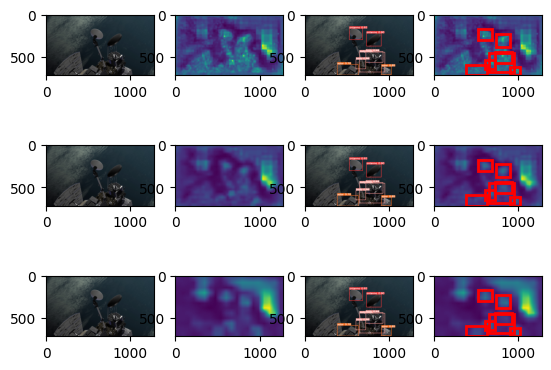


frame00062


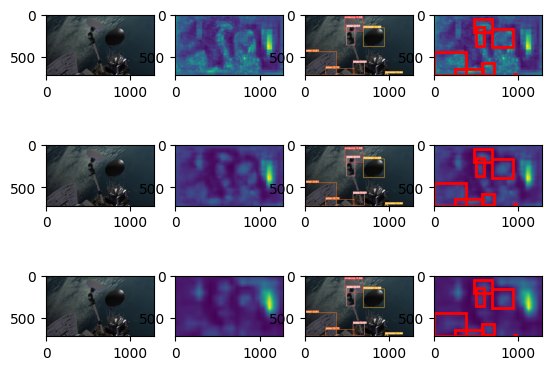


frame00099


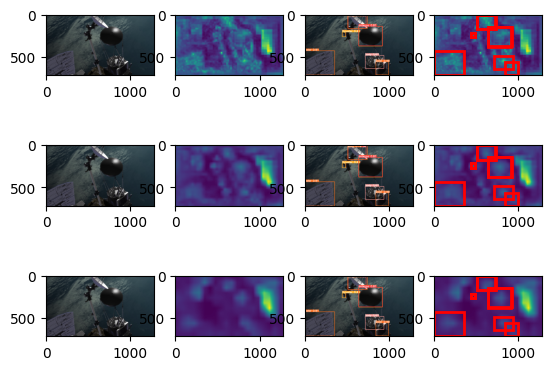


frame00177


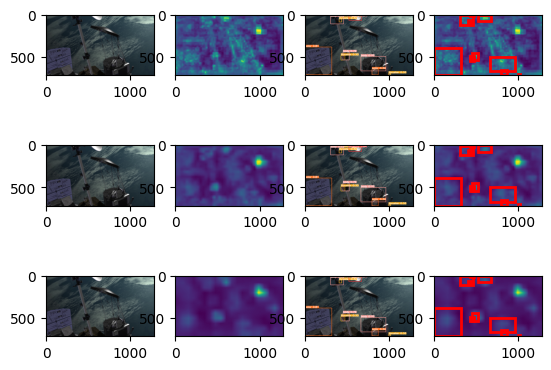


frame00286


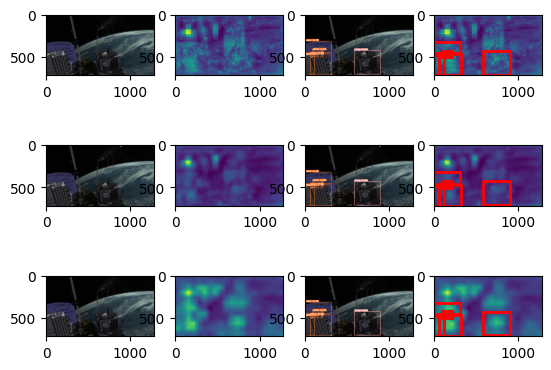


frame00327


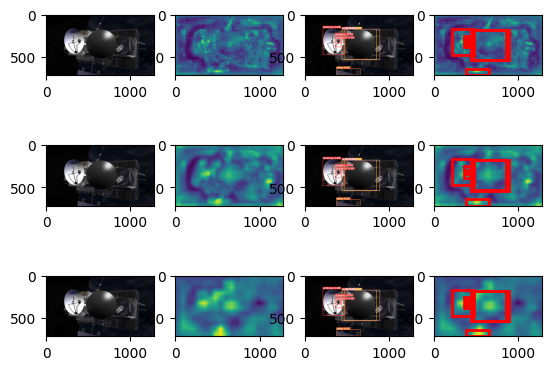


frame01421


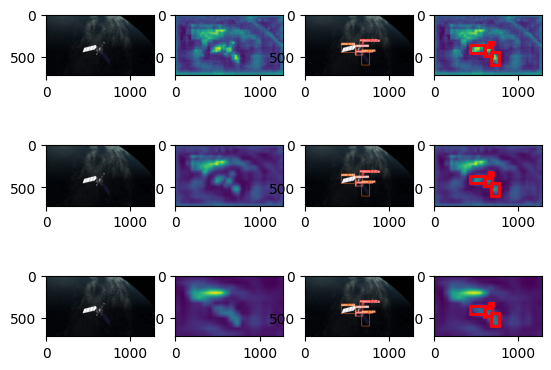


frame01424


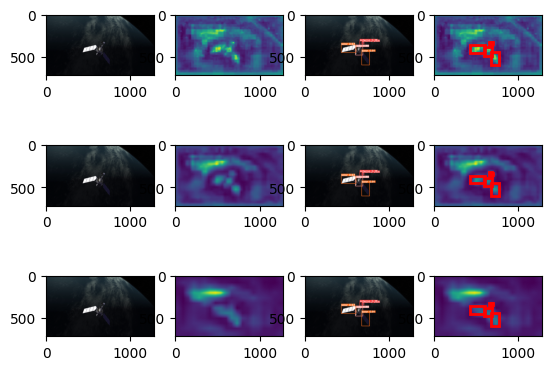

In [3]:
import glob
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from peek.functions import compute_PEEK

feature_map_filepaths = glob.glob('feature_maps/GSFC/*')
prediction_txt_filepaths = glob.glob('yolov5/runs/detect/PEEK_boxes2/labels/*')
image_filepaths = glob.glob('TestData/*')
annotated_image_filepaths = glob.glob('yolov5/runs/detect/PEEK_boxes2/*.png')

modules = [16, 19, 22]

for fmap_path, pred_path, img_path, ann_img_path in zip(feature_map_filepaths, prediction_txt_filepaths, image_filepaths, annotated_image_filepaths):
    fig, axes = plt.subplots(3, 4)
    print(f'\n{os.path.split(fmap_path)[-1][:-4]}')
    
    image = plt.imread(img_path)
    h, w, _ = image.shape
    
    annotated_img = plt.imread(ann_img_path)
    
    with open(fmap_path, 'rb') as file:
        fmaps = pickle.load(file)
        
    with open(pred_path, 'r') as file:
        bounding_boxes = [[int(w) for w in line.strip().split()[1:-1]] for line in file]
        
    for i, m in enumerate(modules):
        feature_maps = fmaps[m][0].cpu().numpy()
        feature_maps = np.moveaxis(feature_maps, 0, -1)
        #print(feature_maps.shape)
        peek_map = compute_PEEK(feature_maps, h, w)
        axes[i, 0].imshow(image)
        axes[i, 1].imshow(peek_map)
        axes[i, 2].imshow(annotated_img)
        axes[i, 3].imshow(peek_map)
        
        for bbox in bounding_boxes:
            x1, y1, x2, y2 = bbox
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            
            # Add the rectangle to the plot
            axes[i, 3].add_patch(rect)

            # Optionally annotate the box
            #axes[i, 3].text(x1, y1, f'({x1},{y1},{x2},{y2})', color='blue', fontsize=10)


    plt.show()

## Extract YOLO-predicted Bboxes from PEEK

In [4]:
import glob
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from peek.functions import compute_PEEK

feature_map_filepaths = glob.glob('feature_maps/GSFC/*')
prediction_txt_filepaths = glob.glob('yolov5/runs/detect/PEEK_boxes2/labels/*')
image_filepaths = glob.glob('TestData/*')
annotated_image_filepaths = glob.glob('yolov5/runs/detect/PEEK_boxes2/*.png')

modules = [16, 19, 22]

PEEK_regions = []

for fmap_path, pred_path, img_path, ann_img_path in zip(feature_map_filepaths, prediction_txt_filepaths, image_filepaths, annotated_image_filepaths):
    print(f'\n{os.path.split(fmap_path)[-1][:-4]}')
    PEEK_regions_for_img = []
    h, w, _ = image.shape
        
    with open(fmap_path, 'rb') as file:
        fmaps = pickle.load(file)
        
    with open(pred_path, 'r') as file:
        bounding_boxes = [[int(w) for w in line.strip().split()[1:-1]] for line in file]
        
    for i, m in enumerate(modules):
        feature_maps = fmaps[m][0].cpu().numpy()
        feature_maps = np.moveaxis(feature_maps, 0, -1)
        #print(feature_maps.shape)
        peek_map = compute_PEEK(feature_maps, h, w)
        PEEK_regions_for_img_module = []
        
        for bbox in bounding_boxes:
            x1, y1, x2, y2 = bbox
            PEEK_regions_for_img_module += [peek_map[y1:y2, x1:x2]]
            
        PEEK_regions_for_img += [PEEK_regions_for_img_module]
        
    PEEK_regions += [PEEK_regions_for_img]


frame00000

frame00062

frame00099

frame00177

frame00286

frame00327

frame01421

frame01424


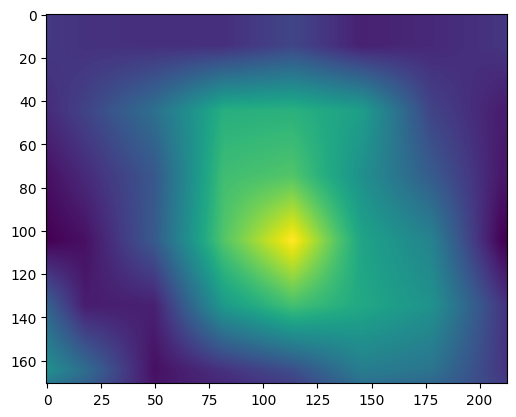

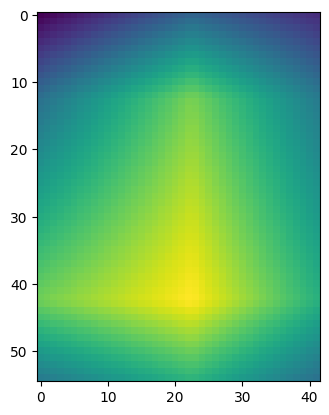

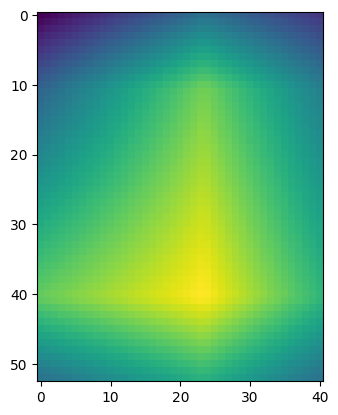

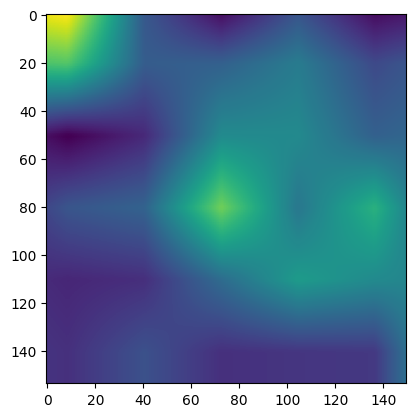

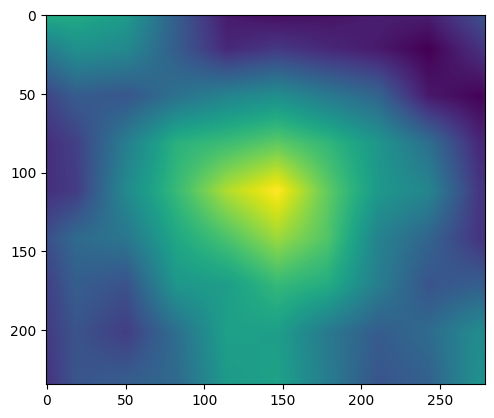

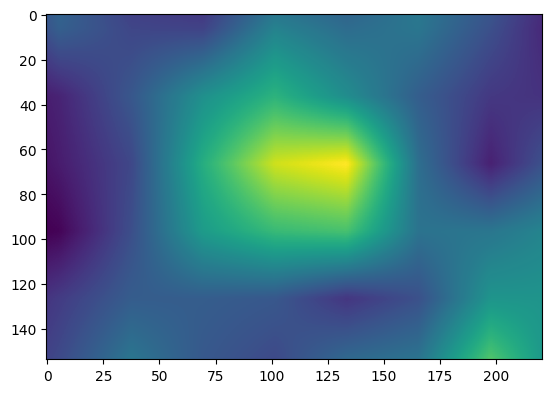

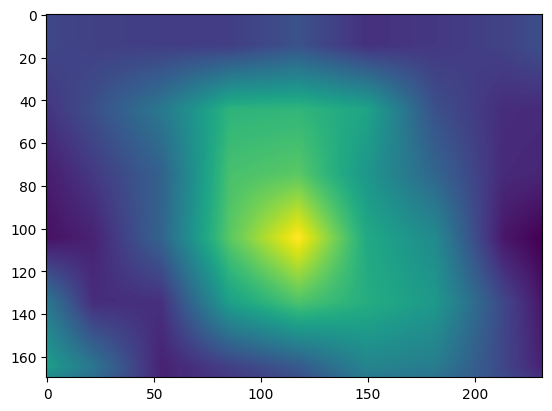

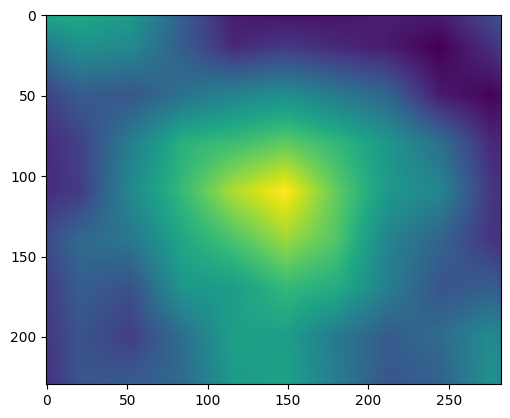

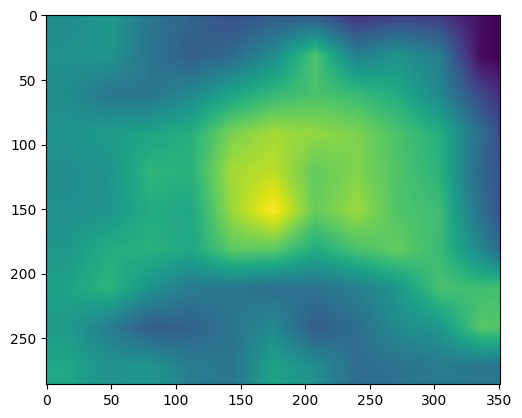

In [5]:
# PEEK_regions
# first index: image number (0-7)
# second index: module (0-2) [assuming we use the 3 head modules]
# third index: bounding box number (0-?) [each image has a different number of bounding boxes]

# EXAMPLE
# PEEK_regions[2][1][4] would be the third image (2), second module (1), and fifth bounding box (4)

# plot all PEEK regions for image 3, module 2 (#19 in this case)
for PEEK_region in PEEK_regions[2][1]:
    plt.imshow(PEEK_region)
    plt.show()

## PEEK-based Region Proposals

Single-PEEK version of the code in `Object_Detection_Pipeline.ipynb` from `ECCV_PEEK` folder.

In [6]:
import cv2

from scipy.special import expit

def propose_regions_given_peek(peek):
    regions = []
  
    standardized_peek = (peek - np.mean(peek)) / np.std(peek)
    # standardized_peeks = np.array(standardized_peeks)

    # idea: make the threshold increase smoothly and look for when the box starts accelerating in size -- stop there
    for i, multiplier in enumerate([1]):
        sigmoid_peek = expit(multiplier*standardized_peek)
        sigmoid_peek = sigmoid_peek > 0.9
            
        # threshold means and find binary mask
        sigmoid_peek = 255*sigmoid_peek.astype(np.uint8)
        thresh_value = 255/2.
        _, binary_mask = cv2.threshold(sigmoid_peek, thresh_value, 1, cv2.THRESH_BINARY)

        kernel = np.ones((5,5),np.uint8)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

        regions += find_rectangles(binary_mask)

    return regions

def find_rectangles(binary_mask):
    regions = []
    min_contour_area = 1000
            
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            x, y, w, h = cv2.boundingRect(contour)
            if [x, y, w, h] != [0, 0, 224, 224]:
                cv2.rectangle(binary_mask, (x, y), (x + w, y + h), (255, 255, 255), 2)
                regions.append([x, y, x + w, y + h])
            
    return regions

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    
    Args:
    - box1: list or array of format [x1_min, y1_min, x1_max, y1_max]
    - box2: list or array of format [x2_min, y2_min, x2_max, y2_max]
    
    Returns:
    - IoU: Intersection over Union between box1 and box2
    """
    
    # Coordinates of the intersection box
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])
    
    # Compute intersection area
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    intersection_area = inter_width * inter_height
    
    # Areas of the two boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Union area
    union_area = box1_area + box2_area - intersection_area
    
    # IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    
    return iou


frame00000


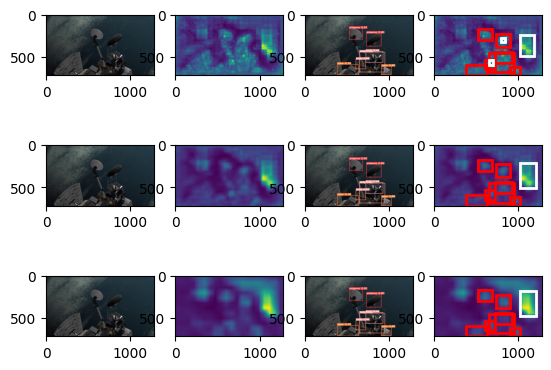


frame00062


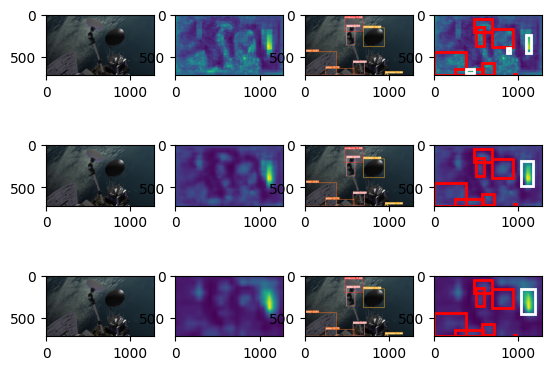


frame00099


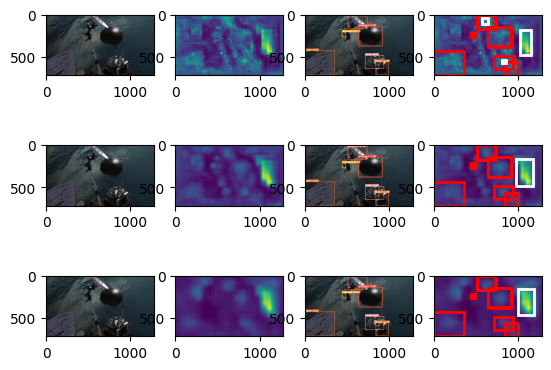


frame00177


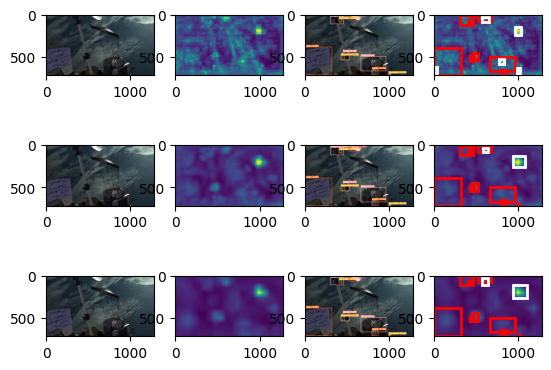


frame00286


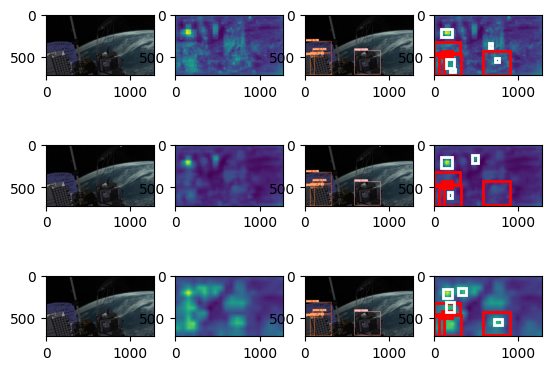


frame00327


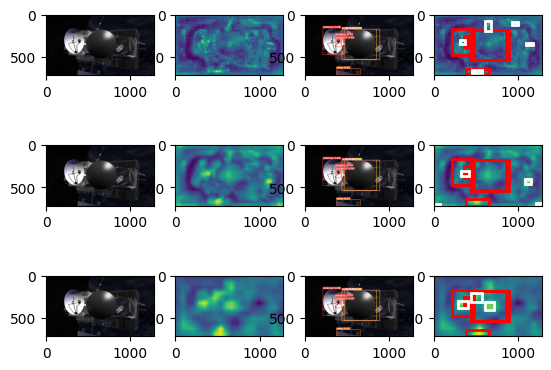


frame01421


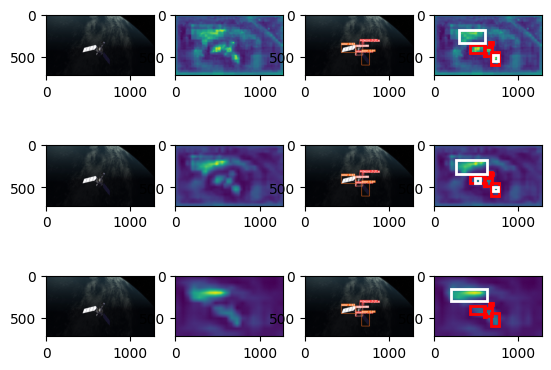


frame01424


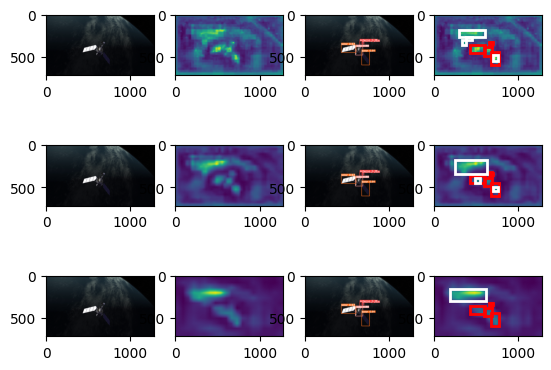

In [7]:
feature_map_filepaths = glob.glob('feature_maps/GSFC/*')
prediction_txt_filepaths = glob.glob('yolov5/runs/detect/PEEK_boxes2/labels/*')
image_filepaths = glob.glob('TestData/*')
annotated_image_filepaths = glob.glob('yolov5/runs/detect/PEEK_boxes2/*.png')

modules = [16, 19, 22]

for fmap_path, pred_path, img_path, ann_img_path in zip(feature_map_filepaths, prediction_txt_filepaths, image_filepaths, annotated_image_filepaths):
    fig, axes = plt.subplots(3, 4)
    print(f'\n{os.path.split(fmap_path)[-1][:-4]}')
    
    image = plt.imread(img_path)
    h, w, _ = image.shape
    
    annotated_img = plt.imread(ann_img_path)
    
    with open(fmap_path, 'rb') as file:
        fmaps = pickle.load(file)
        
    with open(pred_path, 'r') as file:
        bounding_boxes = [[int(w) for w in line.strip().split()[1:-1]] for line in file]
        
    for i, m in enumerate(modules):
        feature_maps = fmaps[m][0].cpu().numpy()
        feature_maps = np.moveaxis(feature_maps, 0, -1)
        #print(feature_maps.shape)
        peek_map = compute_PEEK(feature_maps, h, w)
        peek_bboxes = propose_regions_given_peek(peek_map)
        bboxes = bounding_boxes + peek_bboxes
        
        #print(f'Module {m} PEEK boxes: {peek_bboxes}')
        
        axes[i, 0].imshow(image)
        axes[i, 1].imshow(peek_map)
        axes[i, 2].imshow(annotated_img)
        axes[i, 3].imshow(peek_map)
        
        rectangles = []
        
#         for bbox in bboxes:
#             x1, y1, x2, y2 = bbox
#             width = x2 - x1
#             height = y2 - y1
            
#             rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            
#             # Add the rectangle to the plot
#             axes[i, 3].add_patch(rect)

#             # Optionally annotate the box
#             #axes[i, 3].text(x1, y1, f'({x1},{y1},{x2},{y2})', color='blue', fontsize=10)
        
        for bbox in bounding_boxes:
            x1, y1, x2, y2 = bbox
            width = x2 - x1
            height = y2 - y1

            # make a rectangle
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')

            # Add the rectangle to the plot
            axes[i, 3].add_patch(rect)
            
            rectangles.append(bbox)

        for bbox in peek_bboxes:
            bad_box_flag = False
            
            for rectangle in rectangles + bounding_boxes:
                #print(bbox, rectangle)
                #print(calculate_iou(bbox, rectangle))
                if calculate_iou(bbox, rectangle) > 0.3:
                    bad_box_flag = True

            if not bad_box_flag:
                rectangles.append(bbox)
                x1, y1, x2, y2 = bbox
                width = x2 - x1
                height = y2 - y1
                
                if width*height > 1000:
                    # make a rectangle
                    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='white', facecolor='none')

                    # Add the rectangle to the plot
                    axes[i, 3].add_patch(rect)

    plt.show()